# **Task 1: Retrain the model**

We make use of helper functions created by pytorch to assist us in our tasks.  <br />

Clone the git respositories containing the modules we will be using and appending `sys.path` to the created directory.


In [ ]:
#clone git respositories containing helper functions
!git clone https://github.com/pytorch/vision.git
#append the created directory so that modules can be imported directly
import sys
sys.path.append("/content/vision/references/detection")

data = "/content/drive/My Drive/PennFudanPed"

Cloning into 'vision'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9780 (delta 2), reused 1 (delta 0), pack-reused 9777
Receiving objects: 100% (9780/9780), 11.48 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (6803/6803), done.


The dataset we will be using is Penn-Fudan dataset at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip  <br /> 

We will be trying to detect human pedestrians in this task.

We create a custom `torch.utils.data.Dataset` class to load the data we have downloaded.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

We make use of transfer learning by using the resnet50 network avaliable from COCO and fine tuning it to fit our task.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

By doing data augmentation , it allows our model to generalise better and prevent it from memorising the task.  <br />

Also, we make sure not to forget to convert our PIL image into a PyTorch Tensor so that it can be fed into our model.

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Finally, we instantiate our dataset, model and data transformation and proceed to train our model.

In [ ]:
# load dataset
dataset = PennFudanDataset(data, get_transform(train=True))
dataset_test = PennFudanDataset(data, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

We choose to use the stochastic gradient descent here to estimate our loss.

The way stochastic gradient descent works is that it tries to estimate the gradient through mini batches instead of just a single data. This can help convergence for our optimization process and prevents it from being stuck in a local minimal.

In [ ]:
# use gpu when avaliable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params,lr = 0.01)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Training for 30 epochs , we see that our Average Precision using the metric bbox IoU from range 0.5 to 0.95 is at 0.832, which means that our prediction overlaps with our groundtruth mask by 83.2%. For segm IoU , we get 75.7%. This is quite a good result considering our small dataset!

Do remember to save our model after training so that it can be used locally.

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model.state_dict(), '/content/drive/My Drive/'+ 'PennResnet50.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/60]  eta: 0:03:39  lr: 0.000090  loss: 3.6577 (3.6577)  loss_classifier: 0.7385 (0.7385)  loss_box_reg: 0.2383 (0.2383)  loss_mask: 2.6621 (2.6621)  loss_objectness: 0.0151 (0.0151)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 3.6646  data: 1.9704  max mem: 2299
Epoch: [0]  [10/60]  eta: 0:00:41  lr: 0.000936  loss: 1.6728 (2.2310)  loss_classifier: 0.4477 (0.4977)  loss_box_reg: 0.2956 (0.3001)  loss_mask: 0.9252 (1.4010)  loss_objectness: 0.0183 (0.0273)  loss_rpn_box_reg: 0.0046 (0.0048)  time: 0.8258  data: 0.1874  max mem: 2855
Epoch: [0]  [20/60]  eta: 0:00:27  lr: 0.001783  loss: 1.0025 (1.5281)  loss_classifier: 0.2374 (0.3397)  loss_box_reg: 0.2549 (0.2734)  loss_mask: 0.4219 (0.8850)  loss_objectness: 0.0183 (0.0238)  loss_rpn_box_reg: 0.0046 (0.0062)  time: 0.5351  data: 0.0078  max mem: 2856
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.6351 (1.2154)  loss_classifier: 0.0940 (0.2559)  loss_box_reg: 0.1895 (0.2569)  loss_mask: 0.2532 (0.6776)  loss_ob

Now, we want to test our model on a random image that we pick from the dataset. 

Lets choose one with many humans in the picture and see how well it can detect them.

In [22]:
img, _ = dataset_test[15]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device).cpu()])

This is the image we are testing our model on.

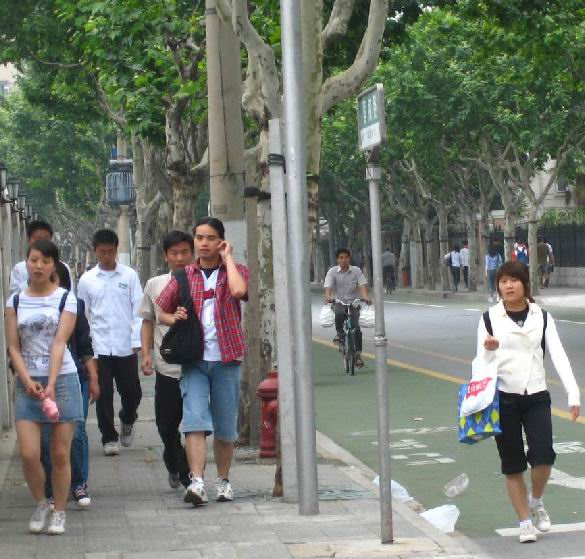

In [23]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

We randomly choose one from 10 different colours to decide our mask colour.

In [ ]:
import random
def random_colour_masks(image):
 
        colours = [[0, 0, 255],[0, 255, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190    , 190]]
        r = np.zeros_like(image).astype(np.uint8)
        g = np.zeros_like(image).astype(np.uint8)
        b = np.zeros_like(image).astype(np.uint8)
        r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
        coloured_mask = np.stack([r, g, b], axis=2)
        return coloured_mask

We visualise the the bbox as well as the mask colour by looping through the masks and mixing the colours of the image with each other.

It appears that our model was able to detect the pedestrains quite well!

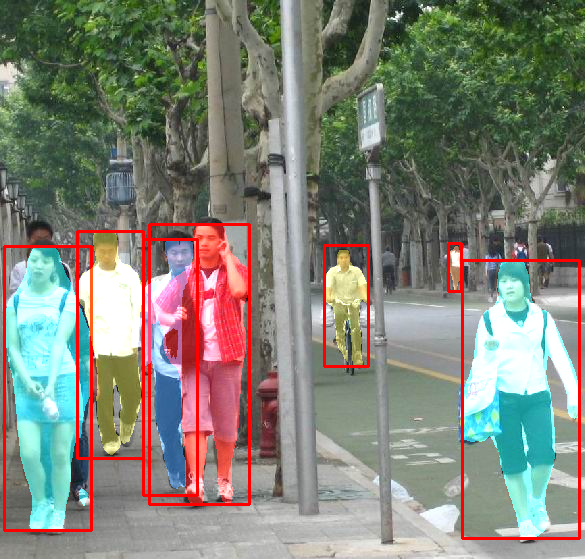

In [25]:
import cv2
from google.colab.patches import cv2_imshow

from torchvision import transforms

#we are only interested in 80% or higher probability mask
noOfMasks = sum(prediction[0]['scores']>0.8).item()
to_pil = transforms.ToPILImage()
IMAGE = to_pil(img)
img_cv = cv2.cvtColor(np.array(IMAGE), cv2.COLOR_RGB2BGR)
#extract prediction box and mask from prediction
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(prediction[0]['boxes'].cpu().detach().numpy())]
masks = (prediction[0]['masks']>0.5).squeeze().detach().cpu().numpy()
for i in range(noOfMasks):
    # iterate over masks
    rgb_mask = random_colour_masks(masks[i])
    img_cv = cv2.addWeighted(img_cv,1,rgb_mask,0.5,0)
    cv2.rectangle(img_cv,pred_boxes[i][0],pred_boxes[i][1],color    =(0,0,255),thickness = 2)

cv2_imshow(img_cv)